In [1]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.driver.memory", "4g").getOrCreate()

# Load and create dataframe

In [2]:
from pyspark.sql.types import *

schema = StructType([
    StructField('duration', IntegerType(), True),
    StructField('protocol_type', StringType(), True),
    StructField('service', StringType(), True),
    StructField('flag', StringType(), True),
    StructField('src_bytes', IntegerType(), True),
    StructField('dst_bytes', IntegerType(), True),
    StructField('land', IntegerType(), True),
    StructField('wrong_fragment', IntegerType(), True),
    StructField('urgent', IntegerType(), True),
    StructField('hot', IntegerType(), True),
    StructField('num_failed_logins', IntegerType(), True),
    StructField('logged_in', IntegerType(), True),
    StructField('num_compromised', IntegerType(), True),
    StructField('root_shell', IntegerType(), True),
    StructField('su_attempted', IntegerType(), True),
    StructField('num_root', IntegerType(), True),
    StructField('num_file_creations', IntegerType(), True),
    StructField('num_shells', IntegerType(), True),
    StructField('num_access_files', IntegerType(), True),
    StructField('num_outbound_cmds', IntegerType(), True),
    StructField('is_host_login', IntegerType(), True),
    StructField('is_guest_login', IntegerType(), True),
    StructField('count', IntegerType(), True),
    StructField('srv_count', IntegerType(), True),
    StructField('serror_rate', FloatType(), True),
    StructField('srv_serror_rate', FloatType(), True),
    StructField('rerror_rate', FloatType(), True),
    StructField('srv_rerror_rate', FloatType(), True),
    StructField('same_srv_rate', FloatType(), True),
    StructField('diff_srv_rate', FloatType(), True),
    StructField('srv_diff_host_rate', FloatType(), True),
    StructField('dst_host_count', IntegerType(), True),
    StructField('dst_host_srv_count', IntegerType(), True),
    StructField('dst_host_same_srv_rate', FloatType(), True),
    StructField('dst_host_diff_srv_rate', FloatType(), True),
    StructField('dst_host_same_src_port_rate', FloatType(), True),
    StructField('dst_host_srv_diff_host_rate', FloatType(), True),
    StructField('dst_host_serror_rate', FloatType(), True),
    StructField('dst_host_srv_serror_rate', FloatType(), True),
    StructField('dst_host_rerror_rate', FloatType(), True),
    StructField('dst_host_srv_rerror_rate', FloatType(), True),
    StructField('label', StringType(), True)
])

kddcup_df = spark.read.csv("/data_serving/cleaned_kddcup.data.gz", sep = ',', header = True, schema = schema)
test_df = spark.read.csv("/data_serving/cleaned_test.data.gz", sep = ',', header = True, schema = schema)


### train

In [3]:
kddcup_df = kddcup_df.repartition(10)
kddcup_df.cache()
print("Number of partition: ", kddcup_df.rdd.getNumPartitions())

Number of partition:  10


### test

In [4]:
test_df.cache()
print("Number of partition: ", test_df.rdd.getNumPartitions())

Number of partition:  1


In [5]:
kddcup_df

DataFrame[duration: int, protocol_type: string, service: string, flag: string, src_bytes: int, dst_bytes: int, land: int, wrong_fragment: int, urgent: int, hot: int, num_failed_logins: int, logged_in: int, num_compromised: int, root_shell: int, su_attempted: int, num_root: int, num_file_creations: int, num_shells: int, num_access_files: int, num_outbound_cmds: int, is_host_login: int, is_guest_login: int, count: int, srv_count: int, serror_rate: float, srv_serror_rate: float, rerror_rate: float, srv_rerror_rate: float, same_srv_rate: float, diff_srv_rate: float, srv_diff_host_rate: float, dst_host_count: int, dst_host_srv_count: int, dst_host_same_srv_rate: float, dst_host_diff_srv_rate: float, dst_host_same_src_port_rate: float, dst_host_srv_diff_host_rate: float, dst_host_serror_rate: float, dst_host_srv_serror_rate: float, dst_host_rerror_rate: float, dst_host_srv_rerror_rate: float, label: string]

In [6]:
test_df

DataFrame[duration: int, protocol_type: string, service: string, flag: string, src_bytes: int, dst_bytes: int, land: int, wrong_fragment: int, urgent: int, hot: int, num_failed_logins: int, logged_in: int, num_compromised: int, root_shell: int, su_attempted: int, num_root: int, num_file_creations: int, num_shells: int, num_access_files: int, num_outbound_cmds: int, is_host_login: int, is_guest_login: int, count: int, srv_count: int, serror_rate: float, srv_serror_rate: float, rerror_rate: float, srv_rerror_rate: float, same_srv_rate: float, diff_srv_rate: float, srv_diff_host_rate: float, dst_host_count: int, dst_host_srv_count: int, dst_host_same_srv_rate: float, dst_host_diff_srv_rate: float, dst_host_same_src_port_rate: float, dst_host_srv_diff_host_rate: float, dst_host_serror_rate: float, dst_host_srv_serror_rate: float, dst_host_rerror_rate: float, dst_host_srv_rerror_rate: float, label: string]

# Check duplicate rows before any manipulation

In [7]:
print(f"Number of duplicates in train dataset: {kddcup_df.count() - kddcup_df.distinct().count()}")
print(f"Number of duplicates in test dataset: {test_df.count() - test_df.distinct().count()}")

Number of duplicates in train dataset: 3823439
Number of duplicates in test dataset: 219031


### Remove duplicates

In [8]:
kddcup_distinct_df = kddcup_df.distinct()
kddcup_distinct_df.cache()
# Number of partitions after removing duplicate
print("Number of partitions after removing duplicate: ", kddcup_distinct_df.rdd.getNumPartitions())

Number of partitions after removing duplicate:  200


In [9]:
test_distinct_df = test_df.distinct()
test_distinct_df.cache()
# Number of partitions after removing duplicate
print("Number of partitions after removing duplicate: ", test_distinct_df.rdd.getNumPartitions())

Number of partitions after removing duplicate:  200


### Number of rows after removing duplicates

In [10]:
print("train: ", kddcup_distinct_df.count())
print("test: ", test_distinct_df.count())

train:  1074991
test:  73268


### reduce number of prtitions

In [11]:
kddcup_distinct_df = kddcup_distinct_df.coalesce(10)
kddcup_distinct_df.cache()
print(kddcup_distinct_df.rdd.getNumPartitions())

test_distinct_df = test_distinct_df.coalesce(1)
test_distinct_df.cache()
print(test_distinct_df.rdd.getNumPartitions())

10
1


# Visulization

## Distinct values in each Categorical data

In [12]:
from pyspark.sql import Row

In [13]:
%%time
categorical_dict = {
    "protocol_type": kddcup_distinct_df.select("protocol_type").distinct().count(),
    "service": kddcup_distinct_df.select("service").distinct().count(),
    "flag": kddcup_distinct_df.select("flag").distinct().count(),
    "label": kddcup_distinct_df.select("label").distinct().count(),
}


categorical_data_df = spark.createDataFrame([Row(column=key, Distinc_values_count=value) for key, value in categorical_dict.items()]) 
categorical_data_df

CPU times: user 192 ms, sys: 31.9 ms, total: 224 ms
Wall time: 1.78 s


DataFrame[column: string, Distinc_values_count: bigint]

## Number of each label in dataset

### train

In [14]:
labels_count = kddcup_distinct_df.groupBy("label").count().orderBy("count", ascending=False)
labels_count.cache()
labels_count.show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|          satan|  5019|
|        ipsweep|  3723|
|      portsweep|  3564|
|          smurf|  3007|
|           nmap|  1554|
|           back|   968|
|       teardrop|   918|
|    warezclient|   893|
|            pod|   206|
|   guess_passwd|    53|
|buffer_overflow|    30|
|    warezmaster|    20|
|           land|    19|
|           imap|    12|
|        rootkit|    10|
|     loadmodule|     9|
|      ftp_write|     8|
|       multihop|     7|
|            phf|     4|
|           perl|     3|
|            spy|     2|
+---------------+------+



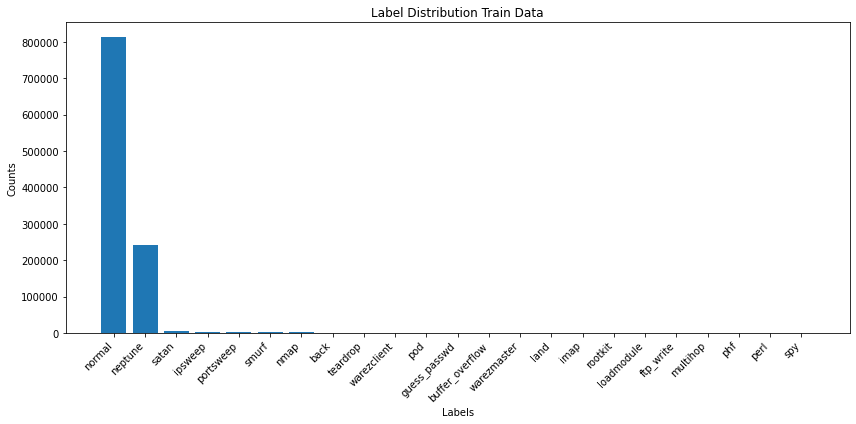

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

labels_count_pd = labels_count.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(labels_count_pd['label'], labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Train Data')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()


### test

In [16]:
labels_count_test = test_distinct_df.groupBy("label").count().orderBy("count", ascending=False)
labels_count_test.cache()
labels_count_test.show(23)

+---------------+-----+
|          label|count|
+---------------+-----+
|         normal|47912|
|        neptune|20332|
|   guess_passwd| 1302|
|    warezmaster| 1002|
|          smurf|  936|
|          satan|  860|
|           back|  386|
|      portsweep|  174|
|        ipsweep|  155|
|           nmap|   80|
|            pod|   45|
|buffer_overflow|   22|
|       multihop|   18|
|        rootkit|   13|
|       teardrop|   12|
|           land|    9|
|      ftp_write|    3|
|            phf|    2|
|           perl|    2|
|     loadmodule|    2|
|           imap|    1|
+---------------+-----+



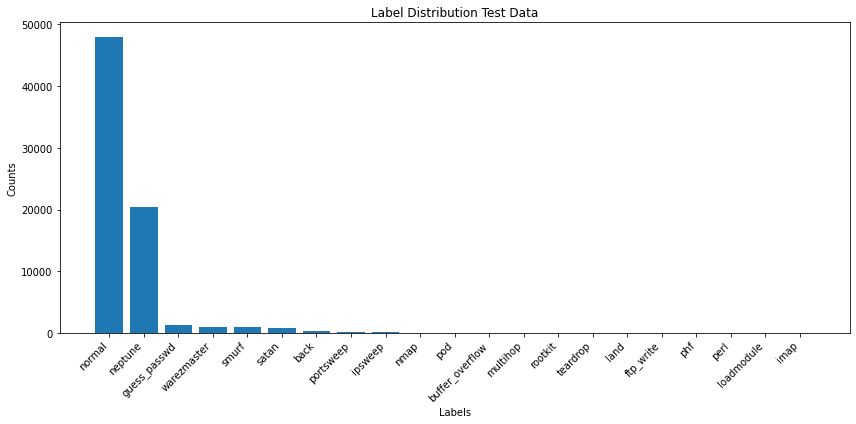

In [17]:
labels_count_pd = labels_count_test.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(labels_count_pd['label'], labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Test Data')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

# Spark MLlib
## Applying Random forest and Logistic Regression on dataset without resampling

## Random Forest Classifier

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler


labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train random forest classifier model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10, maxBins=80)


# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, rf])

# Train model.  This also runs the indexers.

model_ws_rf = pipeline.fit(kddcup_distinct_df)


# Make predictions.

predictions_ws_rf = model_ws_rf.transform(test_distinct_df)

In [19]:
rf = model_ws_rf.stages[-1]
# summary only
print(rf)

RandomForestClassificationModel: uid=RandomForestClassifier_c559168feb95, numTrees=10, numClasses=23, numFeatures=41


In [20]:
# Select example rows to display.
predictions_partial_ws_rf = predictions_ws_rf.select("label", "indexedLabel", "prediction")
predictions_partial_ws_rf.cache()

DataFrame[label: string, indexedLabel: double, prediction: double]

### Evaluate result of Random Forest on dataset without resampling 

In [21]:
from pyspark.sql import functions as F

# count correct and errors
def evaluate_model_ws(pred_df):
    corrects = pred_df.where(F.col("indexedLabel") == F.col("prediction"))
    errors =  pred_df.where(F.col("indexedLabel") != F.col("prediction"))

    correct_counts = corrects.groupBy("label").count().withColumnRenamed("count", "corrects")
    errors_counts = errors.groupBy("label").count().withColumnRenamed("count", "errors")

    # total
    total = pred_df.groupBy("label").count().withColumnRenamed("count", "total")

    # join
    result = total.join(correct_counts, on="label", how="left")
    result = result.join(errors_counts, on="label", how="left")

    # Fill null values for rows where either error or correct is 0
    result = result.na.fill(0, subset=["corrects", "errors"])

    # Order by total predictions
    result = result.orderBy("total", ascending=False)

    result.show(23)

In [22]:
evaluate_model_ws(predictions_partial_ws_rf)
print("Random Forest on dataset without resampling")

+---------------+-----+--------+------+
|          label|total|corrects|errors|
+---------------+-----+--------+------+
|         normal|47910|   47756|   154|
|        neptune|20332|   20306|    26|
|   guess_passwd| 1302|       0|  1302|
|    warezmaster| 1002|       0|  1002|
|          smurf|  936|     925|    11|
|          satan|  860|     838|    22|
|           back|  386|       3|   383|
|      portsweep|  174|     135|    39|
|        ipsweep|  155|     150|     5|
|           nmap|   80|      80|     0|
|            pod|   45|       0|    45|
|buffer_overflow|   22|       0|    22|
|       multihop|   18|       0|    18|
|        rootkit|   13|       0|    13|
|       teardrop|   12|       5|     7|
|           land|    9|       0|     9|
|      ftp_write|    3|       0|     3|
|            phf|    2|       0|     2|
|           perl|    2|       0|     2|
|     loadmodule|    2|       0|     2|
|           imap|    1|       0|     1|
+---------------+-----+--------+------+


In [23]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_ws_rf)
print(f"F1 score: {f1_score}")

F1 score: 0.939710752090198


## Logistic Regression

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, lr])

# Train model.  This also runs the indexers.
model_ws_lr = pipeline.fit(kddcup_distinct_df)

# Make predictions.
predictions_ws_lr = model_ws_lr.transform(test_distinct_df)

In [25]:
lr = model_ws_lr.stages[-1]
# summary only
print(lr)

LogisticRegressionModel: uid=LogisticRegression_4f1ffb1af009, numClasses=23, numFeatures=41


In [26]:
# Select example rows to display.
predictions_partial_ws_lr = predictions_ws_lr.select("label", "indexedLabel", "prediction")
predictions_partial_ws_lr.cache()

DataFrame[label: string, indexedLabel: double, prediction: double]

### Evaluate result of Logistic Regression on dataset without resampling 

In [27]:
# Logistic Regression on dataset without resampling
evaluate_model_ws(predictions_partial_ws_lr)

+---------------+-----+--------+------+
|          label|total|corrects|errors|
+---------------+-----+--------+------+
|         normal|47910|   47280|   630|
|        neptune|20332|   20318|    14|
|   guess_passwd| 1302|       1|  1301|
|    warezmaster| 1002|       0|  1002|
|          smurf|  936|     921|    15|
|          satan|  860|     837|    23|
|           back|  386|     197|   189|
|      portsweep|  174|     162|    12|
|        ipsweep|  155|     149|     6|
|           nmap|   80|      78|     2|
|            pod|   45|      40|     5|
|buffer_overflow|   22|       0|    22|
|       multihop|   18|       0|    18|
|        rootkit|   13|       0|    13|
|       teardrop|   12|      12|     0|
|           land|    9|       8|     1|
|      ftp_write|    3|       0|     3|
|            phf|    2|       1|     1|
|           perl|    2|       1|     1|
|     loadmodule|    2|       0|     2|
|           imap|    1|       0|     1|
+---------------+-----+--------+------+


In [28]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_ws_lr)
print(f"F1 score: {f1_score}")

F1 score: 0.9403078668458779


# OverSampling minor labels

### define function for oversampling

In [29]:
# number of neptune labels can be considered as target_number
def oversampling(df, label, target_number=5000):
    minor_df = df.filter(col("label") == label)
    ratio = target_number / minor_df.count()
    if ratio <= 1:
        return minor_df
    oversampled_df = minor_df.sample(withReplacement=True, fraction=ratio)
    return oversampled_df

In [30]:
# take minor labels in a list
labels_exclude_firstTwo = [row["label"] for row in kddcup_distinct_df.groupBy("label").count().orderBy("count", ascending=True).collect()]

### Create a new dataframe where we join all labels together after oversampling

In [31]:
from pyspark.sql.functions import col
oversampled_df = spark.createDataFrame([], kddcup_df.schema)

for label in labels_exclude_firstTwo:
    oversampled_label_df = oversampling(kddcup_distinct_df, label)
    oversampled_df = oversampled_df.union(oversampled_label_df)

In [32]:
oversampled_df = oversampled_df.coalesce(10)
oversampled_df.cache()
# Take number of partitions after oversampling. It increased by spark to 212
print(oversampled_df.rdd.getNumPartitions())

10


In [33]:
# Number of rows after oversampling
oversampled_df.count()

1159855

In [34]:
# count number of minor labels after oversampling
oversampled_df.groupBy("label").count().orderBy("count", ascending=False).show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|           perl|  5114|
|      portsweep|  5079|
|    warezclient|  5063|
|           nmap|  5049|
|           land|  5045|
|            spy|  5038|
|            phf|  5034|
|   guess_passwd|  5027|
|          satan|  5019|
|          smurf|  4997|
|            pod|  4995|
|    warezmaster|  4990|
|buffer_overflow|  4977|
|           back|  4962|
|        rootkit|  4960|
|     loadmodule|  4959|
|        ipsweep|  4950|
|           imap|  4934|
|       multihop|  4923|
|      ftp_write|  4920|
|       teardrop|  4858|
+---------------+------+



In [35]:
# Ensure oversampling used all different rows of each label. 
# For example, we have only two rows with label 'spy' in original dataset. 
# Oversampling has to include these two rows as original dataset.
oversampled_df.distinct().groupBy("label").count()

DataFrame[label: string, count: bigint]

### Visulize dataset after sampling

In [36]:
sampled_labels_count = oversampled_df.groupBy("label").count().orderBy("count", ascending=False)
sampled_labels_count.cache()
sampled_labels_count.show(23)

+---------------+------+
|          label| count|
+---------------+------+
|         normal|812813|
|        neptune|242149|
|           perl|  5114|
|      portsweep|  5079|
|    warezclient|  5063|
|           nmap|  5049|
|           land|  5045|
|            spy|  5038|
|            phf|  5034|
|   guess_passwd|  5027|
|          satan|  5019|
|          smurf|  4997|
|            pod|  4995|
|    warezmaster|  4990|
|buffer_overflow|  4977|
|           back|  4962|
|        rootkit|  4960|
|     loadmodule|  4959|
|        ipsweep|  4950|
|           imap|  4934|
|       multihop|  4923|
|      ftp_write|  4920|
|       teardrop|  4858|
+---------------+------+



In [37]:
# Distinct values for each label
oversampled_df.distinct().groupBy("label").count().show(23)

+---------------+------+
|          label| count|
+---------------+------+
|          satan|  5019|
|        neptune|242149|
|           nmap|  1490|
|      portsweep|  2701|
|           back|   961|
|    warezclient|   889|
|   guess_passwd|    53|
|         normal|812813|
|        rootkit|    10|
|           perl|     3|
|buffer_overflow|    30|
|       multihop|     7|
|        ipsweep|  2731|
|    warezmaster|    20|
|           imap|    12|
|       teardrop|   911|
|           land|    19|
|            pod|   206|
|      ftp_write|     8|
|          smurf|  2433|
|     loadmodule|     9|
|            phf|     4|
|            spy|     2|
+---------------+------+



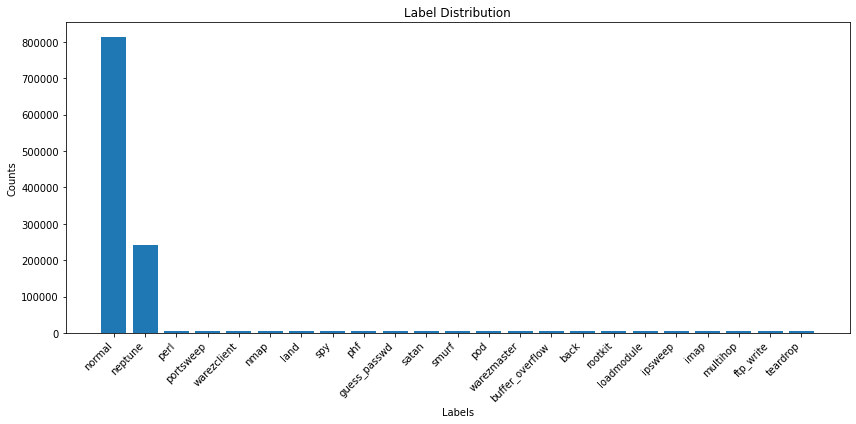

In [38]:
sampled_labels_count_pd = sampled_labels_count.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(sampled_labels_count_pd['label'], sampled_labels_count_pd['count'])
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

## Logistic Regression on dataset with resampling

## Logistic Regression

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel",  handleInvalid="skip")
protocol_typeIndexer = StringIndexer(inputCol="protocol_type", outputCol="indexedProtocol_type",  handleInvalid="skip")
serviceIndexer = StringIndexer(inputCol="service", outputCol="indexedService",  handleInvalid="skip")
flagIndexer = StringIndexer(inputCol="flag", outputCol="indexedFlag",  handleInvalid="skip")

featureAssembler = VectorAssembler(
    inputCols=[
        "duration",
        "indexedProtocol_type",
        "indexedService",
        "indexedFlag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate"
    ],
    outputCol="features"
)


# Train a Logistic Regression model.
lr = LogisticRegression(labelCol="indexedLabel", featuresCol="features")

# Chain indexers and model in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, protocol_typeIndexer, serviceIndexer, flagIndexer, featureAssembler, lr])

# Train model.  This also runs the indexers.
model_s_lr = pipeline.fit(oversampled_df)

# Make predictions.
predictions_s_lr = model_s_lr.transform(test_distinct_df)

In [40]:
lr = model_s_lr.stages[-1]
# summary only
print(lr)

LogisticRegressionModel: uid=LogisticRegression_fbc351a5b26e, numClasses=23, numFeatures=41


In [41]:
# Select example rows to display.
predictions_partial_s_lr = predictions_s_lr.select("label", "indexedLabel", "prediction")


In [42]:
print(predictions_partial_s_lr.rdd.getNumPartitions())
predictions_partial_s_lr.cache()

1


DataFrame[label: string, indexedLabel: double, prediction: double]

In [43]:
predictions_partial_s_lr.count()

73266

In [44]:
# Logistic Regression on dataset with resampling
evaluate_model_ws(predictions_partial_s_lr)

+---------------+-----+--------+------+
|          label|total|corrects|errors|
+---------------+-----+--------+------+
|         normal|47910|   47141|   769|
|        neptune|20332|   20299|    33|
|   guess_passwd| 1302|      94|  1208|
|    warezmaster| 1002|      13|   989|
|          smurf|  936|     932|     4|
|          satan|  860|     822|    38|
|           back|  386|     280|   106|
|      portsweep|  174|     165|     9|
|        ipsweep|  155|     149|     6|
|           nmap|   80|      78|     2|
|            pod|   45|      42|     3|
|buffer_overflow|   22|       3|    19|
|       multihop|   18|       2|    16|
|        rootkit|   13|       1|    12|
|       teardrop|   12|      10|     2|
|           land|    9|       9|     0|
|      ftp_write|    3|       0|     3|
|            phf|    2|       1|     1|
|           perl|    2|       1|     1|
|     loadmodule|    2|       0|     2|
|           imap|    1|       0|     1|
+---------------+-----+--------+------+


In [45]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions_partial_s_lr)
print(f"F1 score: {f1_score}")


F1 score: 0.9470151873532273
